## What is Cosine Similarity?

Cosine similarity intended to formulate the similarity between two different text via the cosine function in trigonometry. In this approach, where the texts are considered as vectors the relationship of the two vectors to each other is expressed at an angle. For two vectors that are completely identical, the cosine similarity will be 1. For vectors that are completely unrelated, this value will be 0. If there is an opposite relationship between the two vectors, this time the cosine similarity value will be -1. (cos0 = 1, cos90 = 0, cos180 = -1)


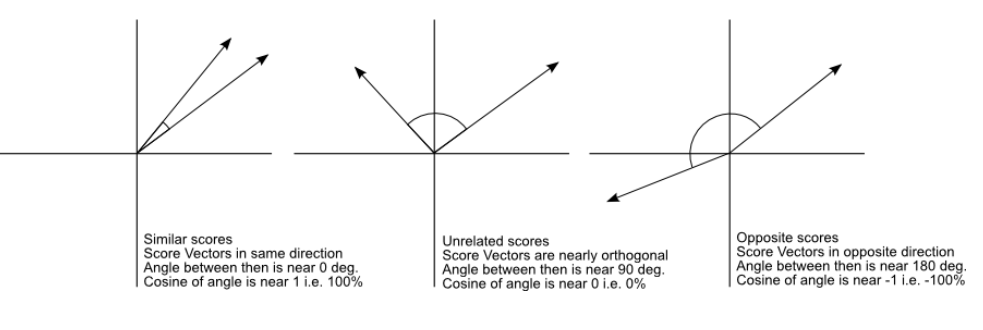

Let's say A and B are text vectors then we will calculate the similarity by using formula below.


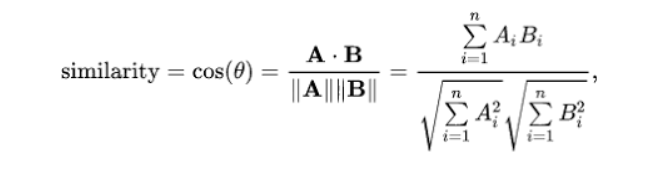

## Importing Necessary Libraries

In [1]:
import numpy as np     
import networkx as nx 
import nltk 
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance


### Adding StopWords


In [2]:
STOP_WORDS = []
try:
    STOP_WORDS = stopwords.words('english')
    if not STOP_WORDS:
        nltk.download('stopwords')
except LookupError:
    nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Cosine Class


In [3]:
class SummariserCosine:
    # Generate clean sentences
    def read_text(self, text):
        """
          Read the passed in text (as string) and split each line,
          that ends with a period (.)
          Replace anything that isn't between
          a to z or A to Z with a space.
          Parameters
          ==========
          text:
             text string to split into individual sentences
          Return
          ======
          Returns a list of sentences split by spaces
        """
        split_text = text.split(". ")

        sentences = []

        for sentence in split_text:
            sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))

        sentences.pop()

        return sentences

    def extract_vector(self, sentence, all_words, stop_words):
        """
          Extract vectors from the sentences,
          skip or ignore stop words from the
          stock of stop words loaded from the nltk library.
          Vectors here mean frequency count of
          the words by index.
          Parameters
          ==========
          sentence:
             a text string representing a sentence
          all_words:
             a list of words including the words in the passed in sentence
          stop_words:
             list of stop words to ignore or not take into consideration
          Return
          ======
          A dictionary of words with frequency of occurence of it in
          the sentence (also called vector)
        """
        extracted_vector = [0] * len(all_words)

        # build the vector for the sentence
        for word in sentence:
            if word in stop_words:
                continue
            extracted_vector[all_words.index(word)] += 1

        return extracted_vector

    # Checking the similarity of the two sentences(adjacent)
    def sentence_similarity(self, first_sentence, second_sentence, stop_words=None):
        """
          Check if two sentences are similar based
          on their vector similarity
          (similar number of frequenting words between them)
          Parameters
          ==========
          first_sentence:
             a text string representing a sentence
          second_sentence:
             another text string representing a sentence
          stop_words:
             list of stop words to ignore or not take into consideration
          Return
          ======
          An decimal representation of the similarity between the
          two sentences (frequency similarity)
        """
        if stop_words is None:
            stop_words = []

        first_sentence = [word.lower() for word in first_sentence]
        second_sentence = [word.lower() for word in second_sentence]

        all_words = list(set(first_sentence + second_sentence))

        first_vector = self.extract_vector(first_sentence, all_words, stop_words)
        second_vector = self.extract_vector(second_sentence, all_words, stop_words)

        return 1 - cosine_distance(first_vector, second_vector)

    # Similarity matrix
    def build_similarity_matrix(self, sentences, stop_words):
        """
          Create an similarity matrix using the sentences,
          round-robbing across all the sentences.
          So we know which sentences are similar
          to others.
          Parameters
          ==========
          first_sentence:
             a text string representing a sentence
          second_sentence:
             another text string representing a sentence
          stop_words:
             list of stop words to ignore or not take into consideration
          Return
          ======
          An decimal representation of the similarity between the
          two sentences (frequency similarity)
        """
        # Create an empty similarity matrix
        similarity_matrix = np.zeros((len(sentences), len(sentences)))

        for this_sentence_index, this_sentence in enumerate(sentences):
            for another_sentence_index, another_sentence in enumerate(sentences):
                if this_sentence == another_sentence: 
                    #ignore if both are same sentences
                    continue
                similarity_matrix[this_sentence_index][another_sentence_index] = \
                    self.sentence_similarity(this_sentence, another_sentence, stop_words)

        return similarity_matrix

    # Construct the summarised text from the ranked sentences
    def summarise_text(self, ranked_sentences, top_n_sentences):
        """
          Rank all the similar sentences based on
          their similarities and then create the
          summarised text from the ranked sentences.
          Parameters
          ==========
          ranked_sentences:
             a list of sentences ranked by their score (descending order)
          top_n_sentences:
             number of sentences to consider from the top of the list
          Return
          ======
          A list of top n sentences ranked by their score (descending order)
        """
        summarised_text = []

        if top_n_sentences > len(ranked_sentences):
            top_n_sentences = len(ranked_sentences)

        for index in range(top_n_sentences):
            summarised_text.append(" ".join(ranked_sentences[index][1]))

        summarised_text = ". ".join(summarised_text)

        return summarised_text

    # Sort sentences to surface top ranked ones from the similarity matrix
    def sort_sentences_to_surface_top_ranked_sentences(self, scores, sentences):
        """
          Sort the sentences to bring the
          top ranked sentences to the surface
          Parameters
          ==========
          scores:
             scores of each of the sentences in the list of sentences
          sentences:
             a list of sentences
          Return
          ======
          a sorted list of sentences based on their scores (highest to lowest)
        """
        return sorted(((scores[index], sentence) \
            for index, sentence in enumerate(sentences)), reverse=True)

    # Rank the sentences using networkx's pagerank() function
    def rank_sentences(self, sentence_similarity_martix):
        """
          Using networkx's pagerank rank the sentences,
          generating a graph and scores for each sentence
          Parameters
          ==========
          sentence_similarity_martix:
            a matrix of sentence similarity (cross sentences)
          Return
          ======
          a sentence similarity graph and scores of the sentences in descending order
        """
        sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
        scores = nx.pagerank(sentence_similarity_graph)
        return sentence_similarity_graph, scores

    # Generating Summary Method
    def generate_summary(self, text, top_n_sentences):
        """
          Generate a summary by processing a text
          through various steps, returning the summarised text
          and a list of ranked sentences from which the
          summary was prepared
          Parameters
          ==========
          text:
            raw text to summarise, usually a long string of text made up of multiple sentences
          top_n_sentences:
            number of sentences to pick from the list of sentences to form the summary
          Return
          ======
          A list sentences that will form the summarised text (top n sentences)
        """

        # Step 1 - Read text and tokenize
        sentences = self.read_text(text)

        # Step 2 - Generate Similary Martix across sentences
        sentence_similarity_martix = self.build_similarity_matrix(sentences, STOP_WORDS)

        # Step 3 - Rank sentences in similarity martix
        sentence_similarity_graph, scores = self.rank_sentences(sentence_similarity_martix)

        # Step 4 - Sort the rank and pick top sentences
        ranked_sentences = self.sort_sentences_to_surface_top_ranked_sentences(scores, sentences)

        # Step 5 - Construct the summarised text
        summarised_text = self.summarise_text(ranked_sentences, top_n_sentences)

        return summarised_text, ranked_sentences


In [9]:
sample_input="Education means considerably more than just teaching a student to read, write, and manipulate numbers. Computers, the Internet, and advanced electronic devices are becoming essential in everyday life and have changed the way information is gathered. How this new technology is utilized in the curriculum and managed by teachers will have an important role to play in widening the resource and knowledge base for all students. Technology affects the way teachers teach and students learn. To make the best use of information technology (IT), schools need a workable plan to fully integrate it into all aspects of the curriculum so students are taught how, why, and when to use technology to further enhance their learning. If a school does not have a clear plan of how and why it wishes to implement IT, then it runs the risk of wasting money. In schools today, nearly all classrooms have access to a computer. However, many schools mistake this as incorporating information technology into the curriculum. School staff need to research what IT is available and what would best serve the school's purpose, not simply purchase the latest equipment. There should be a policy stating how IT is going to assist pupils' development and what teachers want pupils to achieve. Staff members need to be clear about what they want IT to do for them before they can start incorporating it into their lessons. The only way information technology is going to be useful to schools is if all staff members are well-informed and fully supported. It is the principal's responsibility, and should be part of the school's plan, to ensure that all staff are consulted about the changes, and that the change is carefully organised. Some teachers may be resistant, especially if they have not had much experience with computers, so training teachers is essential in implementing IT into the school curriculum. Staff members must feel involved in the process of acquiring technology, and in learning how to operate it, in order for them to increase their confidence in using IT as a curriculum tool. Teachers are only going to be able to incorporate IT into their lessons if they are competent users themselves"

In [15]:
summ = SummariserCosine()
summerised_text, ranked_sentences = summ.generate_summary(sample_input, 8)

In [16]:
print(summerised_text)

To make the best use of information technology (IT), schools need a workable plan to fully integrate it into all aspects of the curriculum so students are taught how, why, and when to use technology to further enhance their learning. The only way information technology is going to be useful to schools is if all staff members are well-informed and fully supported. How this new technology is utilized in the curriculum and managed by teachers will have an important role to play in widening the resource and knowledge base for all students. It is the principal's responsibility, and should be part of the school's plan, to ensure that all staff are consulted about the changes, and that the change is carefully organised. Staff members must feel involved in the process of acquiring technology, and in learning how to operate it, in order for them to increase their confidence in using IT as a curriculum tool. School staff need to research what IT is available and what would best serve the school'

In [17]:
print(' \n•'.join((summerised_text.split('.'))))

To make the best use of information technology (IT), schools need a workable plan to fully integrate it into all aspects of the curriculum so students are taught how, why, and when to use technology to further enhance their learning 
• The only way information technology is going to be useful to schools is if all staff members are well-informed and fully supported 
• How this new technology is utilized in the curriculum and managed by teachers will have an important role to play in widening the resource and knowledge base for all students 
• It is the principal's responsibility, and should be part of the school's plan, to ensure that all staff are consulted about the changes, and that the change is carefully organised 
• Staff members must feel involved in the process of acquiring technology, and in learning how to operate it, in order for them to increase their confidence in using IT as a curriculum tool 
• School staff need to research what IT is available and what would best serve t

In [18]:
print(ranked_sentences)

[(0.0875210934025783, ['To', 'make', 'the', 'best', 'use', 'of', 'information', 'technology', '(IT),', 'schools', 'need', 'a', 'workable', 'plan', 'to', 'fully', 'integrate', 'it', 'into', 'all', 'aspects', 'of', 'the', 'curriculum', 'so', 'students', 'are', 'taught', 'how,', 'why,', 'and', 'when', 'to', 'use', 'technology', 'to', 'further', 'enhance', 'their', 'learning']), (0.08444573324194095, ['The', 'only', 'way', 'information', 'technology', 'is', 'going', 'to', 'be', 'useful', 'to', 'schools', 'is', 'if', 'all', 'staff', 'members', 'are', 'well-informed', 'and', 'fully', 'supported']), (0.08385579041669593, ['How', 'this', 'new', 'technology', 'is', 'utilized', 'in', 'the', 'curriculum', 'and', 'managed', 'by', 'teachers', 'will', 'have', 'an', 'important', 'role', 'to', 'play', 'in', 'widening', 'the', 'resource', 'and', 'knowledge', 'base', 'for', 'all', 'students']), (0.08291265948562641, ['It', 'is', 'the', "principal's", 'responsibility,', 'and', 'should', 'be', 'part', 'of

### Output Comparison:

In [13]:
len(sample_input)

2186

In [19]:
len(summerised_text)

1319